# Heart Attack Dataset: Cleaning, Preprocessing, and EDA

This notebook performs comprehensive data cleaning and exploratory analysis on the `Heart_Attack.csv` dataset to prepare it for modeling.


## 1. Setup and Initial Data Loading

In this section, we import required libraries, configure plotting style, load the dataset, and inspect basic structure and missingness.


In [65]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot style
sns.set_style("whitegrid")

# Paths
DATA_PATH = "./src/data/Heart_Attack.csv"

# Load data
df = pd.read_csv(DATA_PATH)

# Basic inspection
display(df.head())
print("Current Shape:", df.shape)


,age,sex,Chest pain type,trestbps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,70,1,4,130,322,0,2,109,0,2.4,2,2
1,67,0,3,115,564,0,2,160,0,1.6,2,1
2,57,1,2,124,261,0,0,141,0,0.3,1,2
3,64,1,4,128,263,0,0,105,1,0.2,2,1
4,74,0,2,120,269,0,2,121,1,0.2,1,1


Current Shape: (1763, 12)


## 2. Data Cleaning and Preprocessing

In this section, we clean and preprocess the dataset to ensure consistency and readiness for analysis and modeling.


### 2.1 Handling Duplicates

The dataset contains a significant number of duplicate rows (272 duplicates found in initial analysis). Keeping duplicates can bias analysis and model training. We will remove exact duplicate rows to ensure each observation is counted once.


In [66]:
# Duplicates summary as table
shape_before = df.shape
num_dupes = df.duplicated().sum()

# Remove duplicates
df.drop_duplicates(inplace=True)

# Summarize before/after
dupes_summary = pd.DataFrame([
    {
        'rows_before': shape_before[0],
        'cols_before': shape_before[1],
        'duplicates_before': num_dupes,
        'rows_after': df.shape[0],
        'cols_after': df.shape[1]
    }
])
display(dupes_summary)


,rows_before,cols_before,duplicates_before,rows_after,cols_after
0,1763,12,272,1491,12


### 2.2 Handling Implausible Zero Values (trestbps, cholesterol)

The `trestbps` (resting blood pressure) and `cholesterol` columns contain zeros, which are biologically implausible for living individuals and likely represent missing data placeholders. We'll replace zeros in these columns with `NaN` and impute using the median, which is robust to outliers.


In [67]:
# Zero handling summary tables
cols_zero_to_nan = ['trestbps', 'cholesterol']
summary_rows = []

# Zeros before
for col in cols_zero_to_nan:
    zeros_before = int((df[col] == 0).sum())
    summary_rows.append({'column': col, 'zeros_before': zeros_before})

# Replace zeros with NaN
df[cols_zero_to_nan] = df[cols_zero_to_nan].replace(0, np.nan)

# Median imputation
for col in cols_zero_to_nan:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# After checks
for row in summary_rows:
    col = row['column']
    row['median'] = df[col].median()
    row['zeros_after'] = int((df[col] == 0).sum())
    row['nans_after'] = int(df[col].isna().sum())

zero_summary_df = pd.DataFrame(summary_rows)[['column','zeros_before','median','zeros_after','nans_after']]
display(zero_summary_df)


,column,zeros_before,median,zeros_after,nans_after
0,trestbps,1,130.0,0,0
1,cholesterol,172,240.0,0,0


### 2.3 Correcting Categorical Variable Mappings and Anomalies

We realign categorical variables to standard UCI definitions and remove anomalous values not defined in documentation.

- Target variable: Convert to binary (0: no disease, 1: disease) by merging target values 1 and 2 into 1
- Chest pain type should be in {1,2,3,4}. We'll keep as categorical values. Remove rows with value 0.
- ST slope should be in {1,2,3}. We'll keep as categorical values with mapping: {1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'}. Remove rows with value 0.


In [68]:
# Target variable conversion to binary
print("Target variable value counts before conversion:")
print(df['target'].value_counts(dropna=False).sort_index())

# Convert target to binary: 0 (no disease), 1 (disease)
# Merge target values 1 and 2 into 1 (disease)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

print("\nTarget variable value counts after binary conversion:")
print(df['target'].value_counts(dropna=False).sort_index())
print(f"Binary distribution: {df['target'].value_counts().values} (No disease: {df['target'].value_counts()[0]}, Disease: {df['target'].value_counts()[1]})")


Target variable value counts before conversion:
target
0    574
1    797
2    120
Name: count, dtype: int64

Target variable value counts after binary conversion:
target
0    574
1    917
Name: count, dtype: int64
Binary distribution: [917 574] (No disease: 574, Disease: 917)


In [69]:
# Chest pain type anomaly removal (keep categorical values 1,2,3,4)
cpt_col = 'Chest pain type'
print("Chest pain type value counts before:")
print(df[cpt_col].value_counts(dropna=False).sort_index())

# Identify anomalous 0s
anomalous_cpt = (df[cpt_col] == 0).sum()
anomalous_percentage = anomalous_cpt / len(df) * 100
print(f"Type Chest pain 0 count: {anomalous_cpt} ({anomalous_percentage:.2f}%)")

# Remove rows with Chest pain type == 0
if anomalous_cpt > 0:
    df = df[df[cpt_col] != 0].copy()

# Keep chest pain type as categorical values (1,2,3,4)
print("\nChest pain type (categorical 1-4) value counts after removing anomalous 0s:")
print(df[cpt_col].value_counts(dropna=False).sort_index())
print("Note: Values represent - 1: Typical Angina, 2: Atypical Angina, 3: Non-Anginal Pain, 4: Asymptomatic")

# ST slope anomaly removal (keep categorical values 1,2,3)
# Note: ST slope values represent: {1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'}
slope_col = 'ST slope'
print("\nST slope value counts before:")
print(df[slope_col].value_counts(dropna=False).sort_index())

anomalous_slope = (df[slope_col] == 0).sum()
anomalous_percentage = anomalous_slope / len(df) * 100
print(f"Type ST slope 0 count: {anomalous_slope} ({anomalous_percentage:.2f}%)")

# Remove rows with ST slope == 0 (anomalous values)
if anomalous_slope > 0:
    df = df[df[slope_col] != 0].copy()

print("\nST slope value counts after removing anomalous 0s:")
print(df[slope_col].value_counts(dropna=False).sort_index())
print("Note: Values represent - 1: Upsloping, 2: Flat, 3: Downsloping")


Chest pain type value counts before:
Chest pain type
0     23
1    116
2    301
3    426
4    625
Name: count, dtype: int64
Type Chest pain 0 count: 23 (1.54%)

Chest pain type (categorical 1-4) value counts after removing anomalous 0s:
Chest pain type
1    116
2    301
3    426
4    625
Name: count, dtype: int64
Note: Values represent - 1: Typical Angina, 2: Atypical Angina, 3: Non-Anginal Pain, 4: Asymptomatic

ST slope value counts before:
ST slope
0    134
1    654
2    599
3     81
Name: count, dtype: int64
Type ST slope 0 count: 134 (9.13%)

ST slope value counts after removing anomalous 0s:
ST slope
1    654
2    599
3     81
Name: count, dtype: int64
Note: Values represent - 1: Upsloping, 2: Flat, 3: Downsloping


### 2.4 Feature Engineering for `oldpeak`

`oldpeak` represents ST depression. Negative values likely indicate ST elevation, which we will capture in a new binary feature `ST_elevation`. Then, we'll convert `oldpeak` to its absolute magnitude so it consistently represents the magnitude of ST change.


In [70]:
# Create ST_elevation and adjust oldpeak magnitude
df['ST_elevation'] = (df['oldpeak'] < 0).astype(int)
df['oldpeak'] = df['oldpeak'].abs()

print("ST_elevation value counts:")
print(df['ST_elevation'].value_counts())


ST_elevation value counts:
ST_elevation
0    1321
1      13
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA) on Cleaned Data


### 3.1 Descriptive Statistics


In [71]:
# Descriptive statistics for numerical columns
display(df.describe().T)

# Value counts for categorical columns
categorical_cols = ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', 'target', 'ST_elevation']
for col in categorical_cols:
    if col in df.columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts(dropna=False))


,count,mean,std,min,25%,50%,75%,max
age,1334.0,53.940030,9.275932,28.0,47.0,55.0,61.0,77.0
sex,1334.0,0.753373,0.431209,0.0,1.0,1.0,1.0,1.0
Chest pain type,1334.0,3.158921,0.934585,1.0,3.0,3.0,4.0,4.0
trestbps,1334.0,132.257121,17.917641,80.0,120.0,130.0,140.0,200.0
cholesterol,1334.0,245.488756,53.315543,85.0,214.0,240.0,270.0,603.0
fasting blood sugar,1334.0,0.205397,0.404143,0.0,0.0,0.0,0.0,1.0
resting ecg,1334.0,0.743628,0.892715,0.0,0.0,0.0,2.0,2.0
max heart rate,1334.0,139.621439,25.197016,60.0,122.0,141.0,160.0,202.0
exercise angina,1334.0,0.398051,0.489680,0.0,0.0,0.0,1.0,1.0
oldpeak,1334.0,1.017091,1.101854,0.0,0.0,0.8,1.7,6.2



Value counts for sex:
sex
1    1005
0     329
Name: count, dtype: int64

Value counts for Chest pain type:
Chest pain type
4    625
3    376
2    253
1     80
Name: count, dtype: int64

Value counts for fasting blood sugar:
fasting blood sugar
0    1060
1     274
Name: count, dtype: int64

Value counts for resting ecg:
resting ecg
0    746
2    404
1    184
Name: count, dtype: int64

Value counts for exercise angina:
exercise angina
0    803
1    531
Name: count, dtype: int64

Value counts for ST slope:
ST slope
1    654
2    599
3     81
Name: count, dtype: int64

Value counts for target:
target
1    875
0    459
Name: count, dtype: int64

Value counts for ST_elevation:
ST_elevation
0    1321
1      13
Name: count, dtype: int64


### 3.2 Visualizations (Imagify)


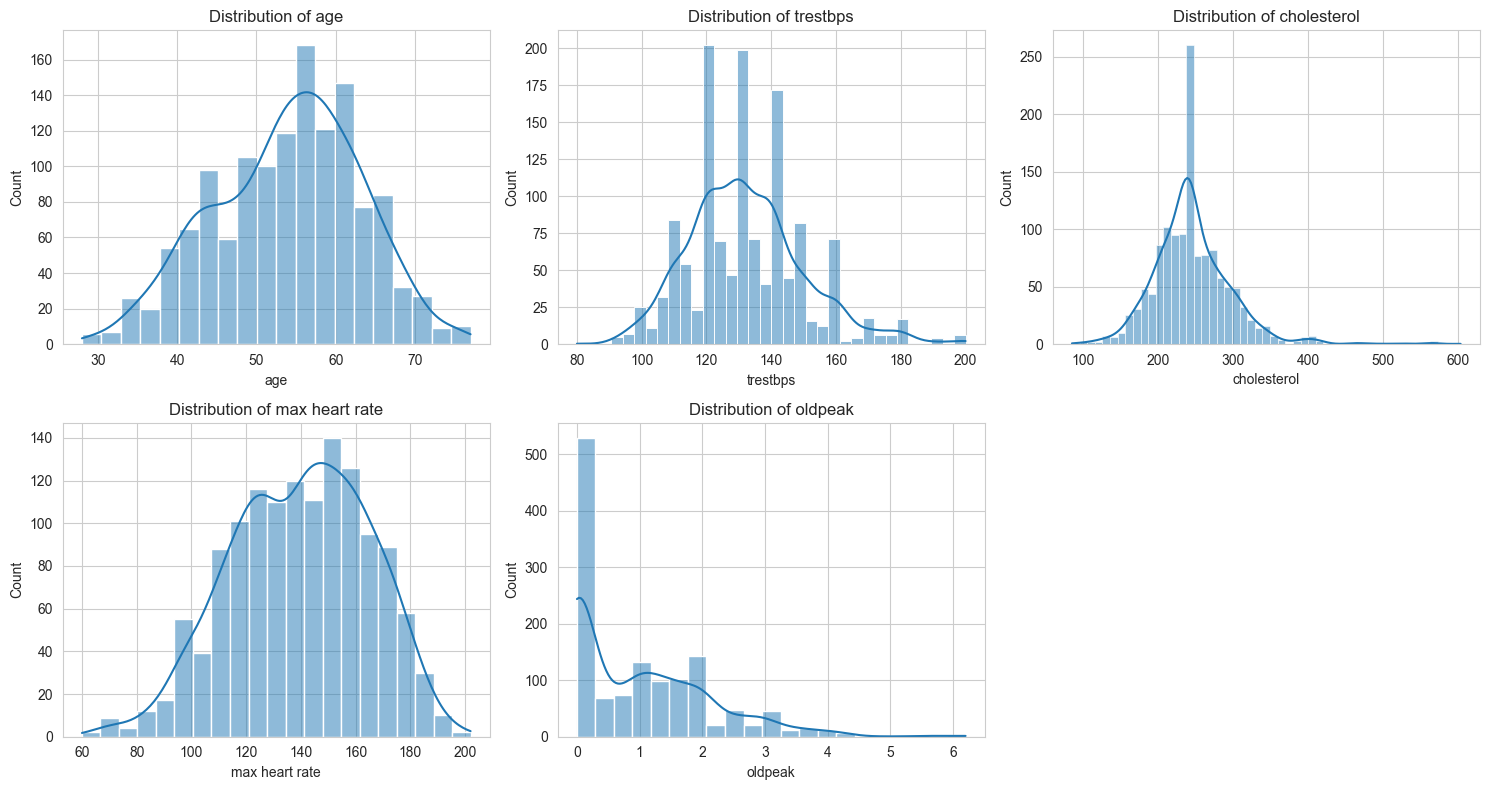

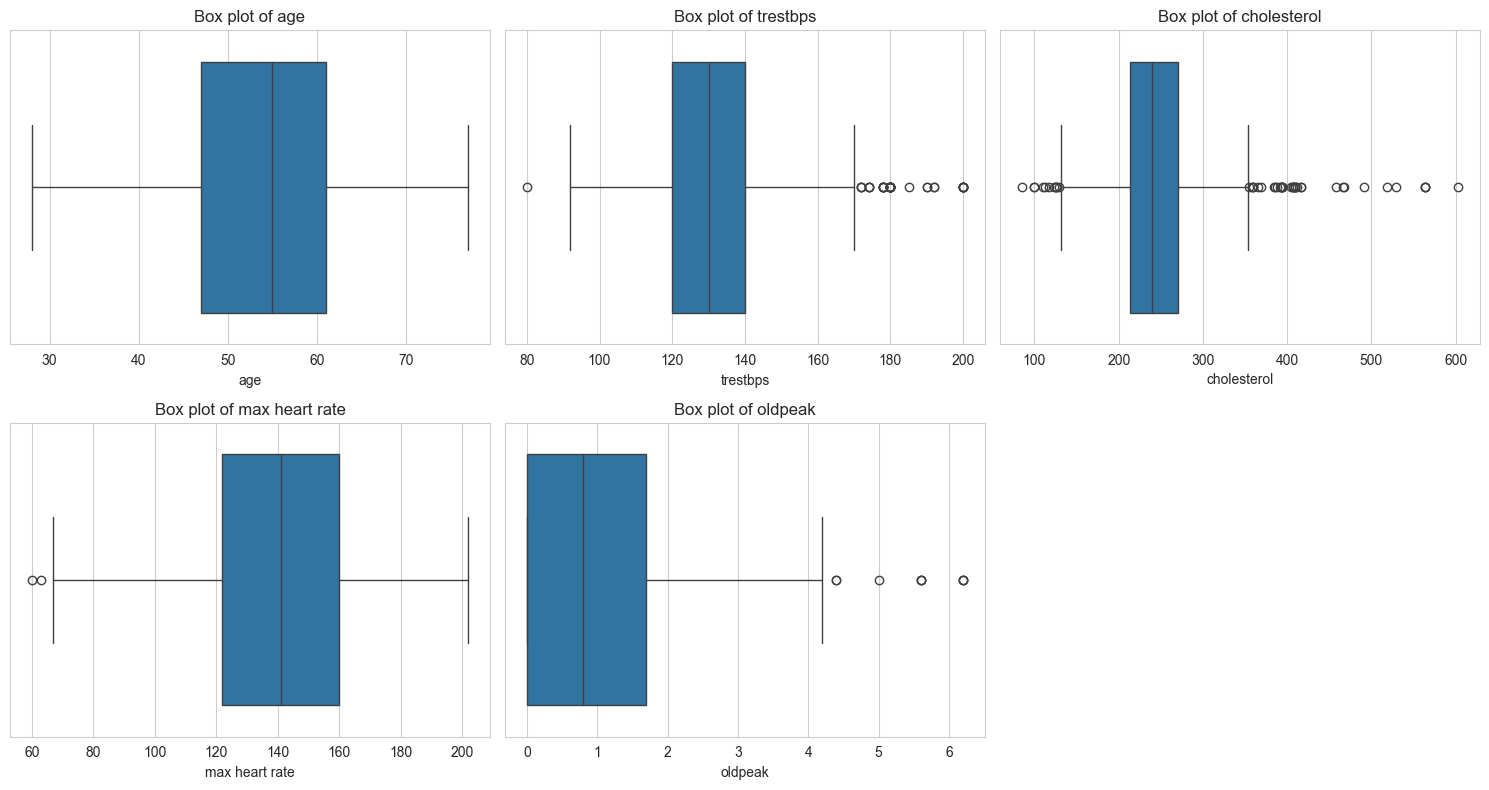

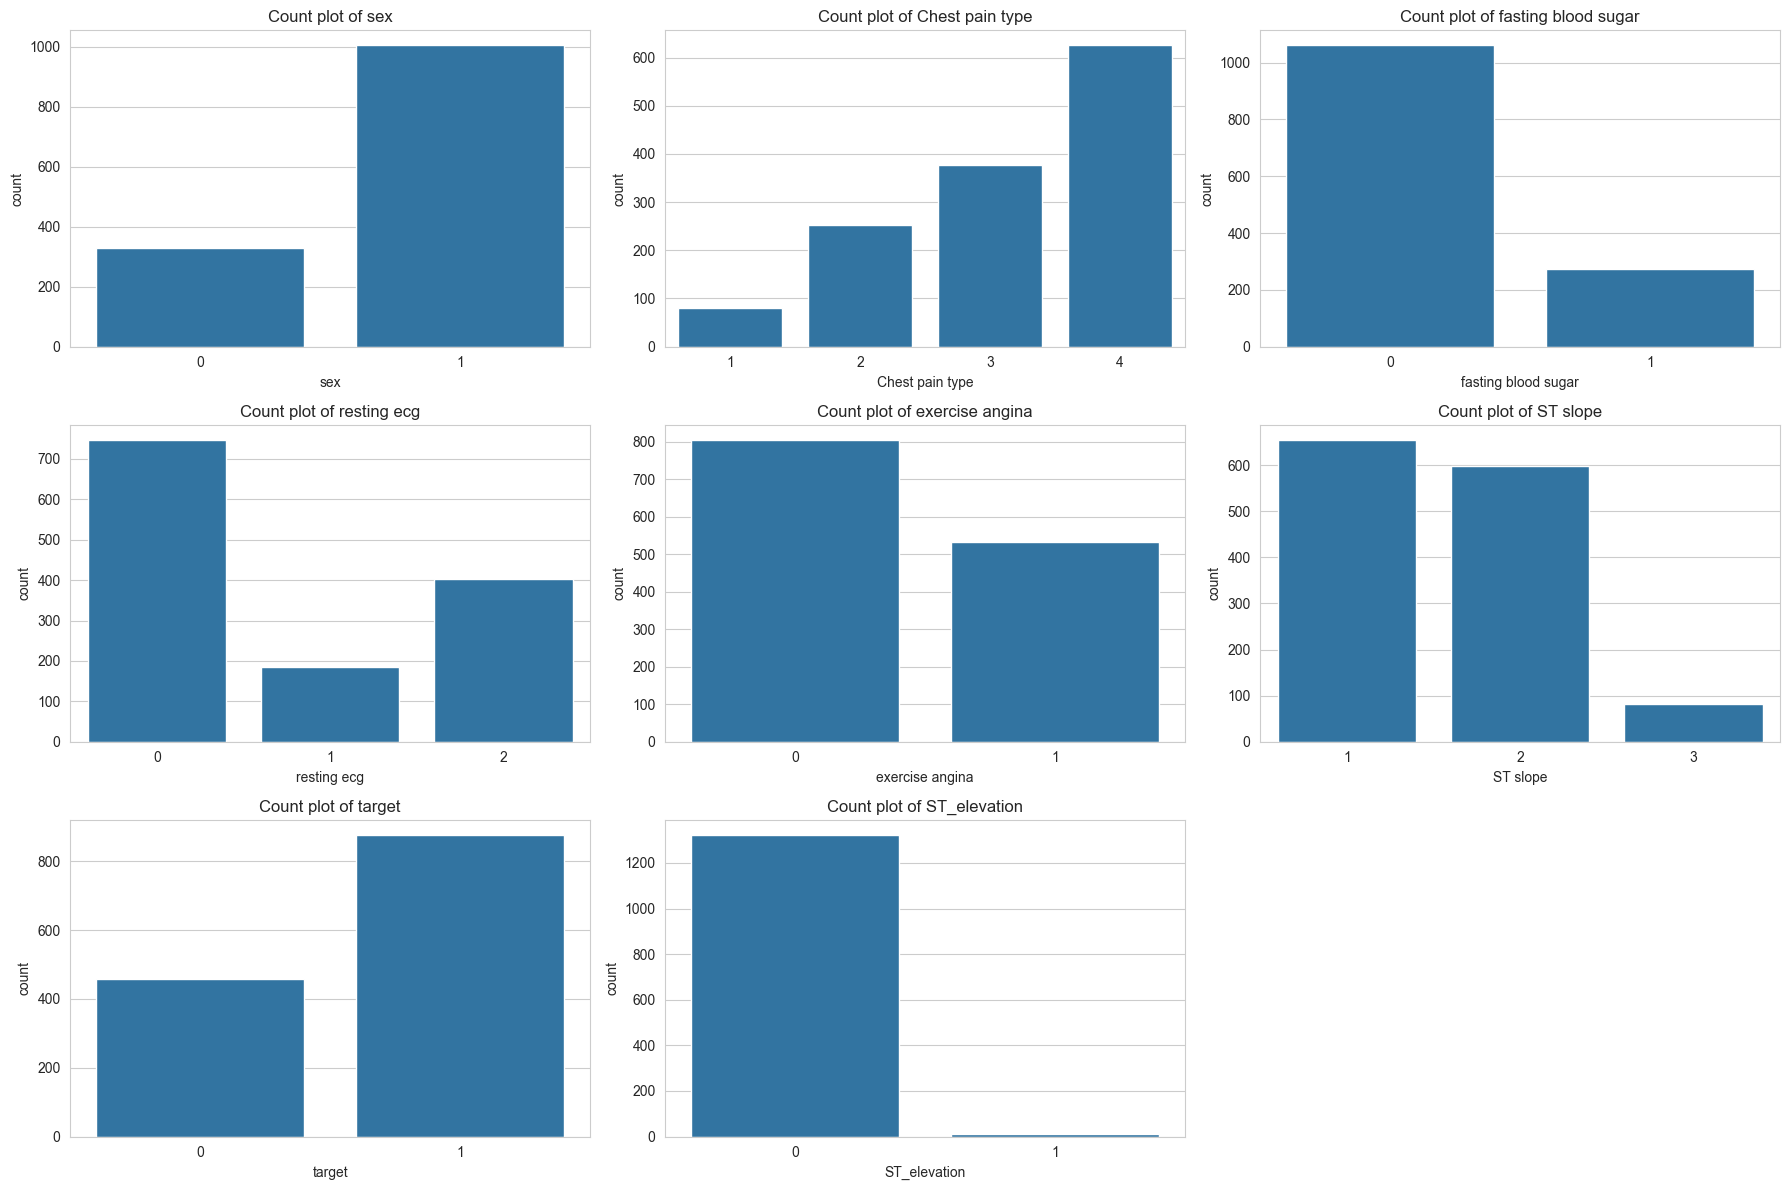

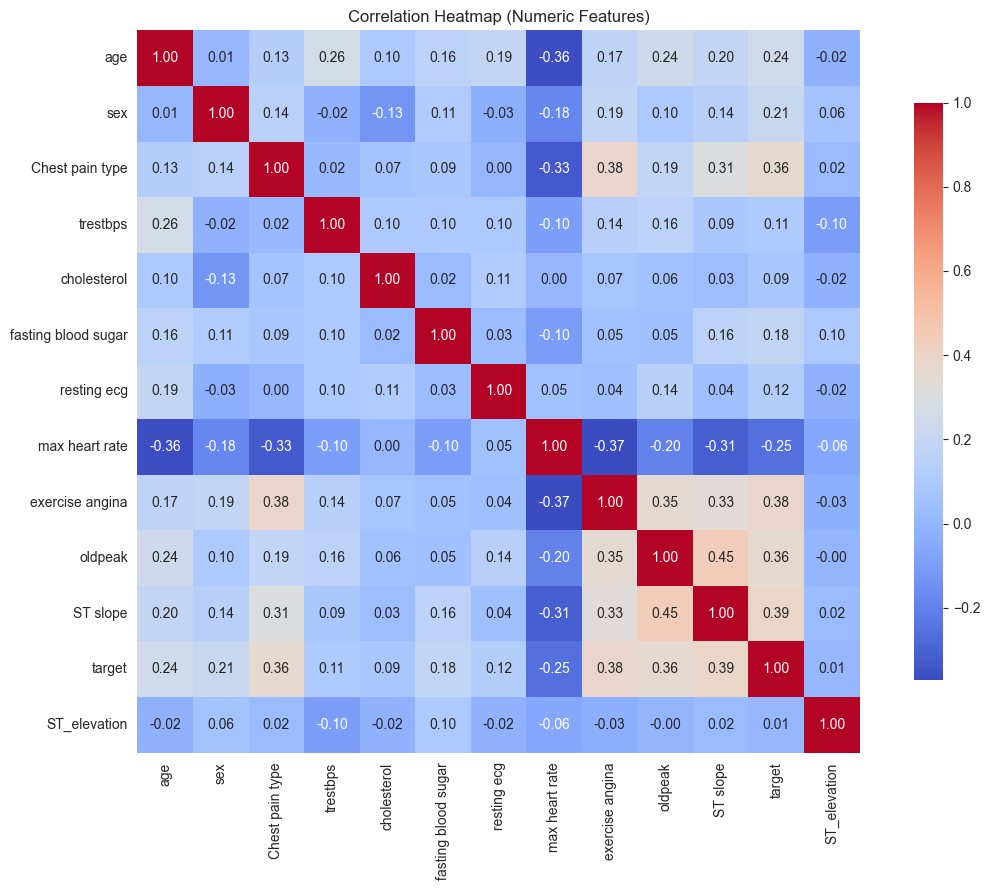

In [72]:
# Distributions of numerical features: histograms with KDE
num_cols = ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
existing_num_cols = [c for c in num_cols if c in df.columns]

fig, axes = plt.subplots(nrows=int(np.ceil(len(existing_num_cols)/3)), ncols=3, figsize=(15, 4*int(np.ceil(len(existing_num_cols)/3))))
axes = np.array(axes).reshape(-1)  # flatten even if single row
for ax, col in zip(axes, existing_num_cols):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
# Hide any unused axes
for ax in axes[len(existing_num_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Box plots for numerical features
fig, axes = plt.subplots(nrows=int(np.ceil(len(existing_num_cols)/3)), ncols=3, figsize=(15, 4*int(np.ceil(len(existing_num_cols)/3))))
axes = np.array(axes).reshape(-1)
for ax, col in zip(axes, existing_num_cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Box plot of {col}")
for ax in axes[len(existing_num_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Categorical count plots
cat_cols = ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', 'target', 'ST_elevation']
existing_cat_cols = [c for c in cat_cols if c in df.columns]

fig, axes = plt.subplots(nrows=int(np.ceil(len(existing_cat_cols)/3)), ncols=3, figsize=(18, 4*int(np.ceil(len(existing_cat_cols)/3))))
axes = np.array(axes).reshape(-1)
for ax, col in zip(axes, existing_cat_cols):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f"Count plot of {col}")
for ax in axes[len(existing_cat_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

# Correlation analysis
# Only include numeric columns for correlation
corr_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


### 3.3 Relationship with Target Variable


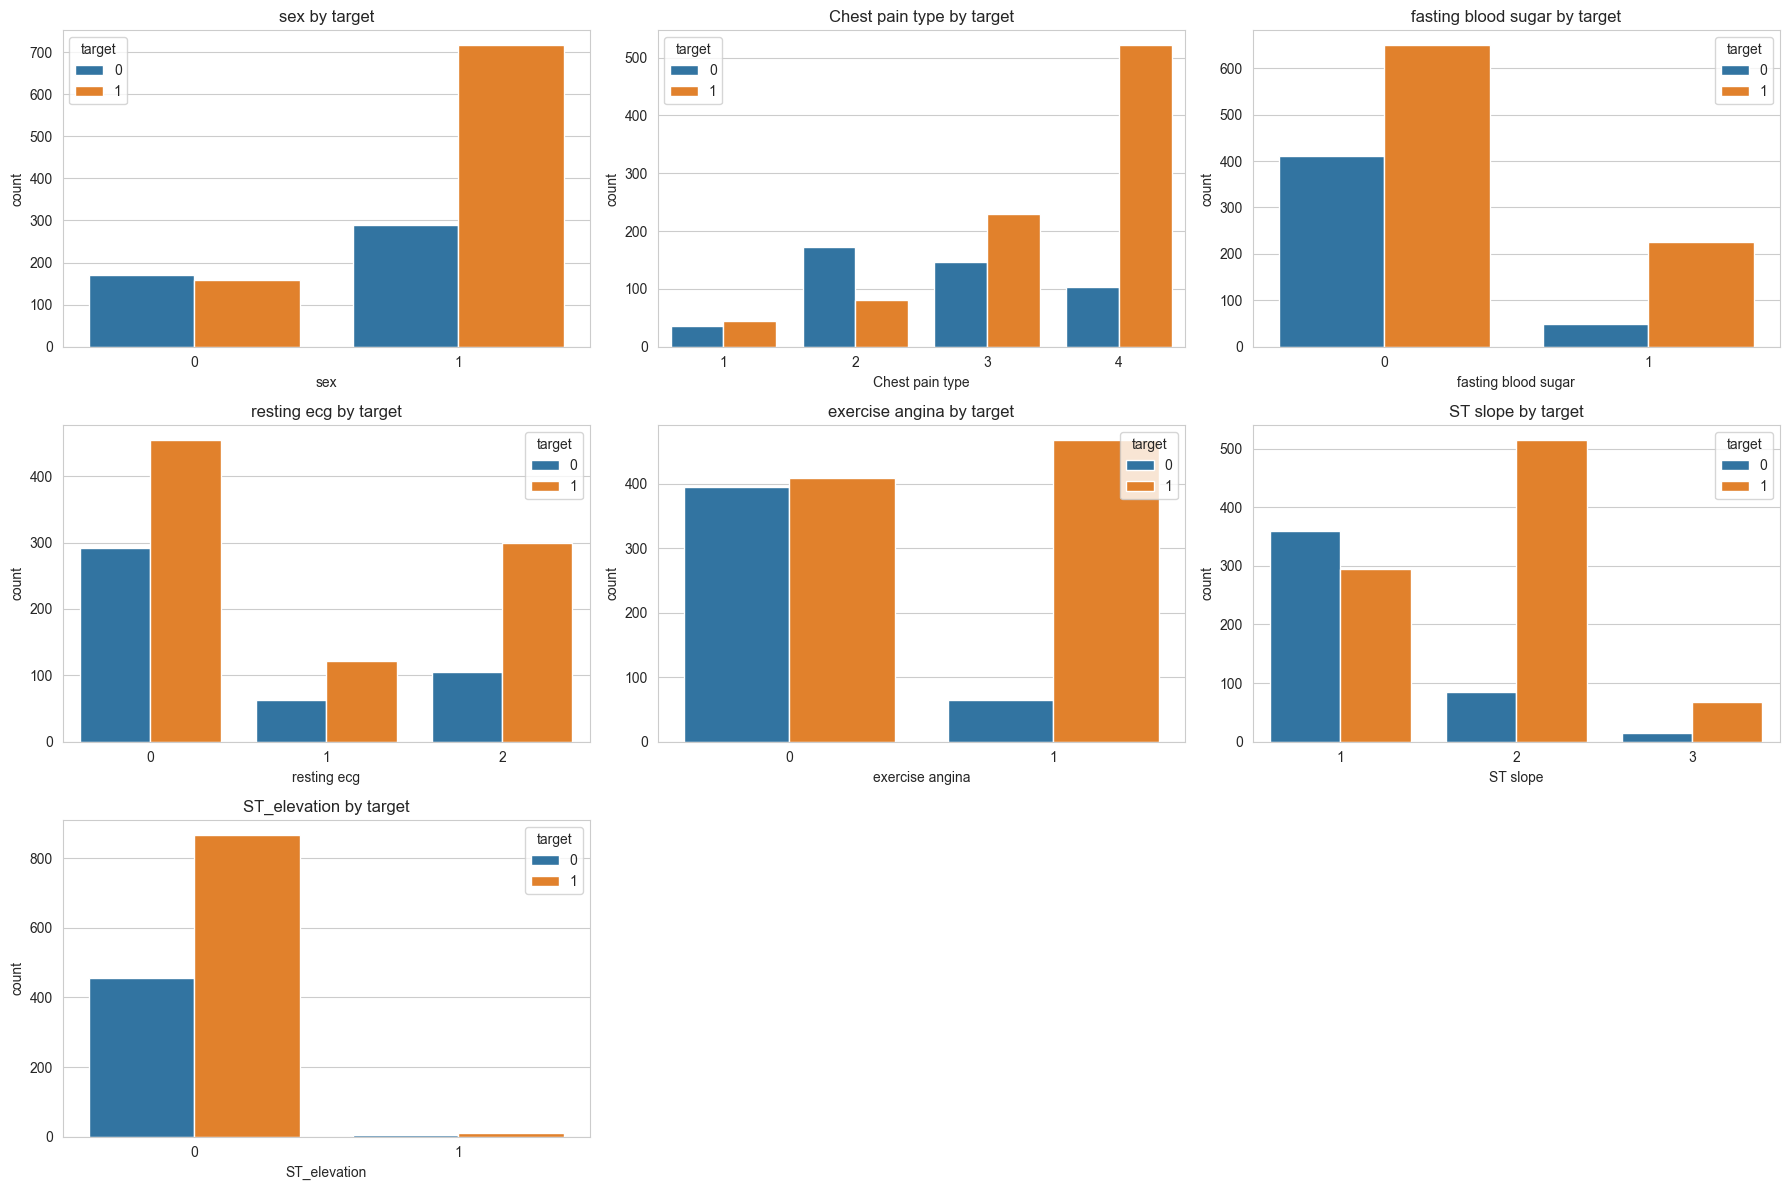

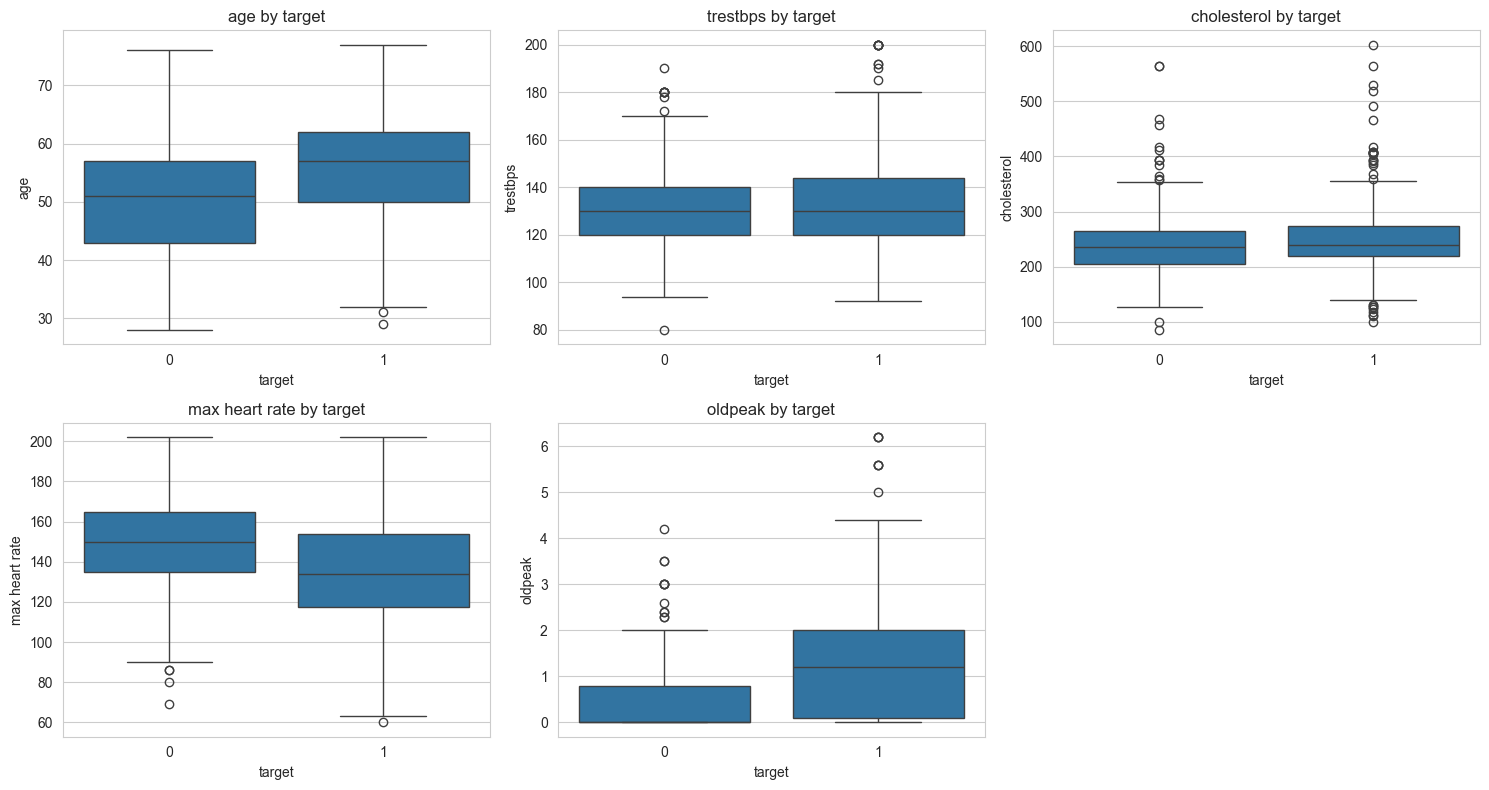

In [73]:
# Count plots of categorical features by target
if 'target' in df.columns:
    cat_cols_target = ['sex', 'Chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', 'ST_elevation']
    cat_cols_target = [c for c in cat_cols_target if c in df.columns]
    fig, axes = plt.subplots(nrows=int(np.ceil(len(cat_cols_target)/3)), ncols=3, figsize=(18, 4*int(np.ceil(len(cat_cols_target)/3))))
    axes = np.array(axes).reshape(-1)
    for ax, col in zip(axes, cat_cols_target):
        sns.countplot(data=df, x=col, hue='target', ax=ax)
        ax.set_title(f"{col} by target")
    for ax in axes[len(cat_cols_target):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

# Box plots of numerical features by target
num_cols_target = ['age', 'trestbps', 'cholesterol', 'max heart rate', 'oldpeak']
num_cols_target = [c for c in num_cols_target if c in df.columns]
fig, axes = plt.subplots(nrows=int(np.ceil(len(num_cols_target)/3)), ncols=3, figsize=(15, 4*int(np.ceil(len(num_cols_target)/3))))
axes = np.array(axes).reshape(-1)
for ax, col in zip(axes, num_cols_target):
    sns.boxplot(data=df, x='target', y=col, ax=ax)
    ax.set_title(f"{col} by target")
for ax in axes[len(num_cols_target):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()


## 4. Save the Cleaned Data

We save the processed DataFrame for downstream modeling steps.


In [74]:
# Save cleaned data
OUTPUT_PATH = "./src/data/Heart_Attack_Cleaned.csv"
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved cleaned data to: {OUTPUT_PATH}")


Saved cleaned data to: ./src/data/Heart_Attack_Cleaned.csv
